## Introduction

The City of New York, is the most populous city in the United States. It is diverse and is the financial capital of USA. It is multicultural. It provides lot of business oppourtunities and business friendly environment. It has attracted many different players into the market. It is a global hub of business and commerce. The city is a major center for banking and finance, retailing, world trade, transportation, tourism, real estate, new media, traditional media, advertising, legal services, accountancy, insurance, theater, fashion, and the arts in the United States. This also means that the market is highly competitive. As it is highly developed city so cost of doing business is also one of the highest. Thus, any new business venture or expansion needs to be analysed carefully. The insights derived from analysis will give good understanding of the business environment which help in strategically targeting the market. This will help in reduction of risk. And the Return on Investment will be reasonable

## Business Problem

  The City of New York is famous for its excelllent cuisine. It's food culture includes an array of international cuisines influenced by the city's immigrant history.
 
  Sushi restaurants have become so popular in the United States now it seems that there is one on every corner, not only in major cities but also in smaller cities. Starting a sushi restaurant can be a great business opportunity, but you need to distinguish yourself from others to enjoy long-term success

## Data Collection

### Neighborhood Data

The data of the neighborhoods in New York was scraped from https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json. The data is read into a pandas data frame using wget download method. The main reason for doing so is that the IMB Cloud provides a comprehensive and detailed table of the data which can easily be used

### Geographical Coordinates

The geographical coordinates for New York data has been obtained from the GeoPy library in python. This data is relevant for plotting the map of New York using the Folium library in python. The geocoder library in python has been used to obtain latitude and longitude data for various neighborhoods in New York. The coordinates of all neighborhoods in New York are used to check the accuracy of coordinates given on Wikipedia and replace them in our data frame if the absolute difference is more than 0.001. These coordinates are then further used for plotting using the Folium library in python.

### Venues Data

The venue data has been extracted using the Foursquare API. This data contains venue recommendations for all neighborhoods in New York and is used to study the popular venues of different neighborhoods.

### Import Libraries

In [181]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score
import requests
from bs4 import BeautifulSoup as bs
import wget
%matplotlib notebook
import time

In [132]:
wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json')
print('Data downloaded!')

100% [............................................................................] 115774 / 115774Data downloaded!


In [130]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [135]:
neigh_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns=column_names)

for data in neigh_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [145]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


We can count the number of neighborhood in each borough and plot it

In [160]:
ny_neigh = neighborhoods.groupby('Borough')['Neighborhood'].nunique()
ny_neigh

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

<IPython.core.display.Javascript object>


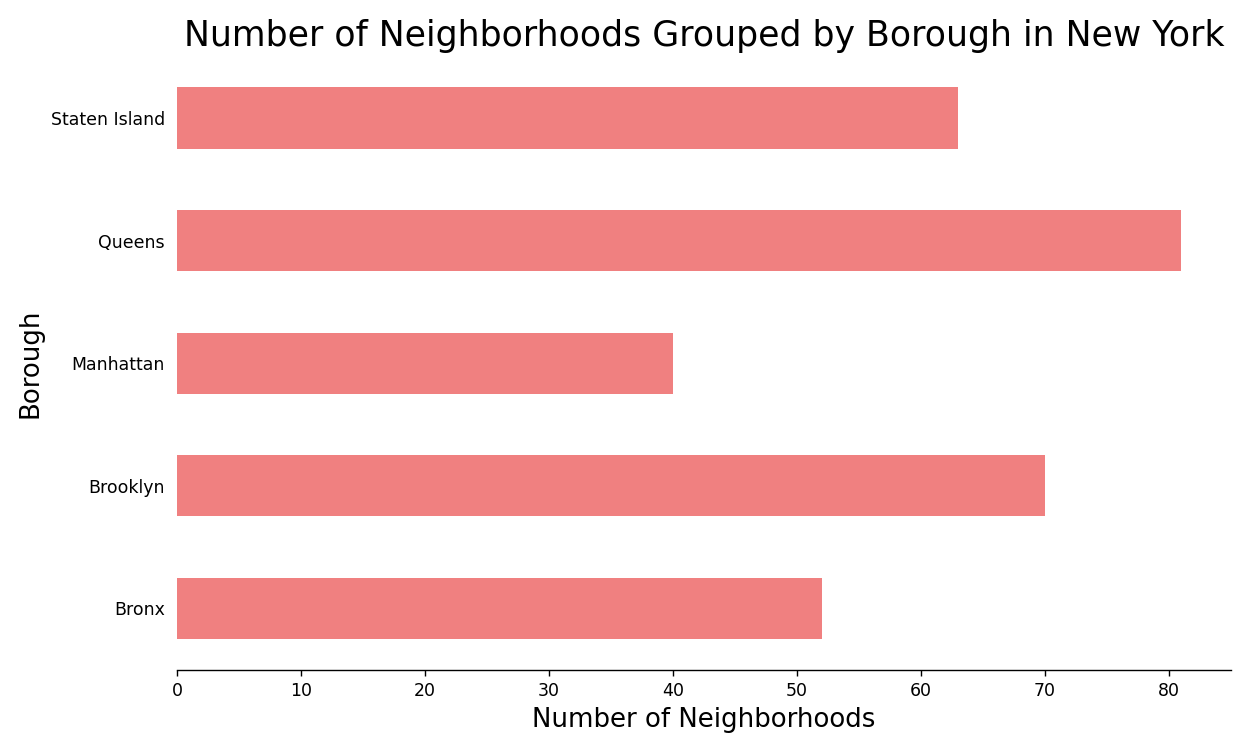

In [149]:
fig = plt.figure(figsize=(10,6))

ax = ny_neigh.plot(kind='barh', color='lightcoral')
ax.set_title('Number of Neighborhoods Grouped by Borough in New York', fontsize=20)
ax.set_xlabel('Number of Neighborhoods', fontsize=15)
ax.set_ylabel('Borough', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)

fig.tight_layout()

Queens, Brooklyn and staten island are the top 3. Now lets visualize the neighborhoods on a map using Folium. First we will obtain the geographical coordinates of New York using GeoPy.

In [154]:
address = 'NewYork, NY'
geolocator = Nominatim(user_agent = 'ny_explorer', timeout = 10)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of New York are 40.710318150000006, -74.00496837048613.


In [161]:
map_ny = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'],
                                           neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

### Using FourSquare API

Now we can start working with the Foursquare API to obtain venue recommendations.

In [162]:
CLIENT_ID = 'SIDEQTEPHOOS3H0D1WXJQSXJA4MXHACOICK235OHYFDDG5SD' 
CLIENT_SECRET = 'GITQ4IDIKRPEUJJI4AL2Y5L4KYU31TDPGBSPBZN5BQSF5HQD'
VERSION = '20210413' 
LIMIT = 100

In [165]:
neighborhood_name = neighborhoods.loc[0, 'Neighborhood']
neighborhood_lat = neighborhoods.loc[0, 'Latitude']
neighborhood_long = neighborhoods.loc[0, 'Longitude']
neighborhood_name
print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The neighborhood is Wakefield and it's geographical coordinates are 40.89470517661 latitude and -73.84720052054902 longitude


Now we can extract Top 100 venues nearby Wakefield with a radius of 1km

In [166]:
LIMIT = 100
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

In [167]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60756bec181886668333a047'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Wakefield',
  'headerFullLocation': 'Wakefield, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 46,
  'suggestedBounds': {'ne': {'lat': 40.903705185610015,
    'lng': -73.83531662200086},
   'sw': {'lat': 40.88570516760999, 'lng': -73.85908441909719}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c537892fd2ea593cb077a28',
       'name': 'Lollipops Gelato',
       'location': {'address': '4120 Baychester Ave',
        'crossStreet': 'Edenwald & Bussing Ave',
        'lat': 40.894123150205274,
        'ln

In [168]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [170]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Ripe Kitchen & Bar,Caribbean Restaurant,40.898152,-73.838875
2,Jackie's West Indian Bakery,Caribbean Restaurant,40.889283,-73.843310
3,Ali's Roti Shop,Caribbean Restaurant,40.894036,-73.856935
4,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568


In [171]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

46 venues were returned for Wakefield by Foursquare


### Generalizing Foursquare API

Now that we have seen how the API call works and how we can clean our data to get relevant information, we can generalize this procedure to get nearby venues for all neighborhoods by creating the function getNearbyVenues.

In [185]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
       ### deal with the ProxyError
        results = ''
        while results == '':
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                break
            except:
                print("Connection refused by the server..")
                print("Let me sleep for 5 seconds")
                print("ZZzzzz...")
                time.sleep(5)
                print("Was a nice sleep, now let me continue...")
                continue
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [269]:
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=radius)

Wakefield
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me contin

Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Rosedale
Far Rockaway
Broad Channel
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Floral Park
Holliswood
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Jamaica Estates
Connection refused by the server..
Let me sleep for 5 seconds
ZZzzzz...
Was a nice sleep, now let me continue...
Queensboro Hill
Hillcrest
Ravenswood
Lind

In [270]:
print(ny_venues.shape)
ny_venues.head(100)

(20634, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
...,...,...,...,...,...,...,...
95,Co-op City,40.874294,-73.829939,Bob's Discount Furniture,40.866814,-73.827436,Furniture / Home Store
96,Co-op City,40.874294,-73.829939,Moe's Southwest Grill,40.866310,-73.830320,Mexican Restaurant
97,Co-op City,40.874294,-73.829939,Mattress Firm,40.868828,-73.833908,Mattress Store
98,Co-op City,40.874294,-73.829939,Mattress Firm,40.868690,-73.826027,Mattress Store


In [271]:
print(ny_venues.isna().any())

Neighborhood              False
Neighborhood Latitude     False
Neighborhood Longitude    False
Venue                     False
Venue Latitude            False
Venue Longitude           False
Venue Category            False
dtype: bool


In [272]:
ny_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allerton,67,67,67,67,67,67
1,Annadale,16,16,16,16,16,16
2,Arden Heights,24,24,24,24,24,24
3,Arlington,20,20,20,20,20,20
4,Arrochar,22,22,22,22,22,22
...,...,...,...,...,...,...,...
297,Woodhaven,66,66,66,66,66,66
298,Woodlawn,51,51,51,51,51,51
299,Woodrow,19,19,19,19,19,19
300,Woodside,100,100,100,100,100,100


In [273]:
print("There are {} unique categories".format(ny_venues['Venue Category'].nunique()))

There are 483 unique categories


### Analyzing each neighborhood

OneHotEncoding

In [274]:
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")
ny_onehot.head()


,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [275]:
ny_onehot['Neighborhood'] = ny_venues['Neighborhood']
ny_onehot.head()

,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Move 'Neighborhood' to first column

In [276]:
temp = list(ny_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [277]:
ny_grouped = ny_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(ny_grouped.shape)
ny_grouped.head(10)

(302, 483)


,Neighborhood,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Wakefield,0.021739,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,Co-op City,0.000000,0.012658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.012658,0.0,0.000000,0.0,0.0
2,Eastchester,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.014706,0.0,0.014706,0.014706,0.0,0.000000,0.0,0.0
3,Fieldston,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.019231,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,Riverdale,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.020833,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
5,Kingsbridge,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.010000,0.0,0.010000,0.000000,0.0,0.010000,0.0,0.0
6,Marble Hill,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.012346,0.0,0.000000,0.000000,0.0,0.012346,0.0,0.0
7,Woodlawn,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
8,Norwood,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
9,Williamsbridge,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


In order to further understand the data, we can display the top 5 venues of all neighborhoods.

In [278]:
num_top_venues = 5

for hood in ny_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Wakefield----
                  venue  freq
0              Pharmacy  0.13
1           Supermarket  0.09
2  Caribbean Restaurant  0.09
3  Fast Food Restaurant  0.07
4            Donut Shop  0.07


----Co-op City----
               venue  freq
0   Department Store  0.06
1  Mobile Phone Shop  0.05
2        Pizza Place  0.05
3           Pharmacy  0.04
4         Shoe Store  0.04


----Eastchester----
                  venue  freq
0  Caribbean Restaurant  0.07
1         Shopping Mall  0.04
2           Pizza Place  0.04
3  Fast Food Restaurant  0.04
4                 Diner  0.04


----Fieldston----
                venue  freq
0         Bus Station  0.10
1                 Bar  0.08
2         Pizza Place  0.08
3       Deli / Bodega  0.06
4  Mexican Restaurant  0.06


----Riverdale----
           venue  freq
0           Bank  0.06
1           Park  0.06
2    Pizza Place  0.06
3            Bar  0.06
4  Deli / Bodega  0.04


----Kingsbridge----
                venue  freq
0         Pizza Place

                venue  freq
0  Italian Restaurant  0.05
1                Café  0.05
2       Deli / Bodega  0.05
3          Playground  0.04
4         Coffee Shop  0.04


----Prospect Heights----
            venue  freq
0             Bar  0.09
1       Wine Shop  0.04
2           Plaza  0.03
3     Coffee Shop  0.03
4  Ice Cream Shop  0.03


----Brownsville----
               venue  freq
0     Discount Store  0.10
1        Pizza Place  0.07
2  Mobile Phone Shop  0.04
3       Liquor Store  0.04
4           Pharmacy  0.04


----Williamsburg----
                 venue  freq
0                  Bar  0.09
1          Pizza Place  0.08
2          Coffee Shop  0.06
3             Wine Bar  0.06
4  American Restaurant  0.05


----Bushwick----
                venue  freq
0                 Bar  0.17
1         Coffee Shop  0.07
2        Cocktail Bar  0.06
3  Mexican Restaurant  0.06
4         Pizza Place  0.04


----Bedford Stuyvesant----
           venue  freq
0    Coffee Shop  0.12
1           Café  



----Inwood----
                       venue  freq
0  Latin American Restaurant  0.06
1              Deli / Bodega  0.05
2         Mexican Restaurant  0.05
3                   Wine Bar  0.04
4                       Café  0.04


----Hamilton Heights----
                venue  freq
0         Coffee Shop  0.06
1  Mexican Restaurant  0.05
2                 Bar  0.05
3  Chinese Restaurant  0.04
4                Park  0.04


----Manhattanville----
                 venue  freq
0          Coffee Shop  0.06
1   Mexican Restaurant  0.04
2   Italian Restaurant  0.04
3                 Park  0.04
4  American Restaurant  0.04


----Central Harlem----
                             venue  freq
0  Southern / Soul Food Restaurant  0.05
1                             Café  0.04
2                     Cocktail Bar  0.03
3             Gym / Fitness Center  0.03
4                              Bar  0.03


----East Harlem----
                venue  freq
0                Café  0.06
1  Mexican Restaurant  0.06
2 

            venue  freq
0   Deli / Bodega  0.10
1            Park  0.10
2     Pizza Place  0.10
3  Discount Store  0.07
4        Bus Stop  0.07


----St. Albans----
                  venue  freq
0  Caribbean Restaurant  0.24
1    Chinese Restaurant  0.14
2           Pizza Place  0.10
3                  Café  0.05
4     Fish & Chips Shop  0.05


----Rochdale----
                 venue  freq
0             Pharmacy  0.14
1        Deli / Bodega  0.07
2          Bus Station  0.07
3  Fried Chicken Joint  0.07
4          Pizza Place  0.07


----Springfield Gardens----
                  venue  freq
0    Chinese Restaurant  0.07
1  Caribbean Restaurant  0.07
2            Donut Shop  0.07
3           Bus Station  0.07
4                   Gym  0.07


----Cambria Heights----
                  venue  freq
0  Caribbean Restaurant  0.11
1              Pharmacy  0.11
2            Restaurant  0.06
3        Cosmetics Shop  0.06
4           Bus Station  0.06


----Rosedale----
                  venue  fr

4       Scenic Lookout  0.05


----Ditmas Park----
                  venue  freq
0  Caribbean Restaurant  0.08
1           Pizza Place  0.07
2    Mexican Restaurant  0.06
3           Coffee Shop  0.05
4        Discount Store  0.04


----Wingate----
                 venue  freq
0        Grocery Store  0.08
1        Deli / Bodega  0.07
2  Fried Chicken Joint  0.07
3          Pizza Place  0.07
4           Donut Shop  0.06


----Rugby----
                  venue  freq
0  Caribbean Restaurant  0.13
1              Pharmacy  0.06
2           Pizza Place  0.06
3         Grocery Store  0.06
4                  Bank  0.05


----Park Hill----
                    venue  freq
0             Pizza Place  0.08
1                Bus Stop  0.08
2           Deli / Bodega  0.04
3           Train Station  0.04
4  Thrift / Vintage Store  0.04


----Westerleigh----
                venue  freq
0  Chinese Restaurant  0.04
1   Convenience Store  0.04
2                Bank  0.04
3              Bakery  0.04
4   Mob

4          Bakery  0.03


----Manor Heights----
           venue  freq
0    Pizza Place  0.09
1  Deli / Bodega  0.09
2     Donut Shop  0.09
3     Bagel Shop  0.09
4  Go Kart Track  0.06


----Willowbrook----
           venue  freq
0       Bus Stop  0.13
1    Pizza Place  0.08
2   Liquor Store  0.08
3  Deli / Bodega  0.08
4     Bagel Shop  0.08


----Sandy Ground----
                venue  freq
0          Donut Shop  0.08
1               Trail  0.04
2            Pharmacy  0.04
3  Miscellaneous Shop  0.04
4          Bagel Shop  0.04


----Egbertville----
            venue  freq
0    Burger Joint  0.08
1      Steakhouse  0.08
2  Clothing Store  0.08
3      Bagel Shop  0.08
4     Flower Shop  0.08


----Roxbury----
            venue  freq
0         Theater  0.09
1  Baseball Field  0.09
2     Art Gallery  0.09
3           Beach  0.09
4      Food Truck  0.05


----Homecrest----
                venue  freq
0       Grocery Store  0.09
1                Bank  0.08
2          Donut Shop  0.05
3  

Let's define a function to get top 5

In [310]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [311]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Wakefield,Pharmacy,Supermarket,Caribbean Restaurant,Donut Shop,Fried Chicken Joint
1,Co-op City,Department Store,Pizza Place,Mobile Phone Shop,Shopping Mall,Pharmacy
2,Eastchester,Caribbean Restaurant,Diner,Pizza Place,Shopping Mall,Fast Food Restaurant
3,Fieldston,Bus Station,Pizza Place,Bar,Deli / Bodega,Mexican Restaurant
4,Riverdale,Bar,Park,Pizza Place,Bank,Bagel Shop
...,...,...,...,...,...,...
297,Hudson Yards,Gym / Fitness Center,Hotel,Theater,Coffee Shop,Lounge
298,Hammels,Beach,Surf Spot,Bar,Wine Bar,Pizza Place
299,Bayswater,Grocery Store,Playground,Park,Chinese Restaurant,Other Great Outdoors
300,Queensbridge,Hotel,Coffee Shop,Café,Sandwich Place,Bar


### Cluterting Neighborhood with KMeans

First we need to determine how many clusters to use. This will be done using the Silhouette Score.

In [312]:
def plot(x, y):
    fig = plt.figure(figsize=(10,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

[0.07366703709513209, 0.06751758788021596, 0.05854703549734176, 0.05267166579946089, 0.060467734356666324, 0.05607097057009369, 0.054645165321843894, 0.059794555434922035, 0.06025950522206473, 0.050272039562732886, 0.04987348061000931, 0.02671346126683116, 0.027497638314107394, 0.04334124409532371, 0.02000930791183606, 0.030830606791048695, 0.04817084233168035, 0.04819836480400702, 0.008413234954090187, 0.025966276025036254, 0.018313458731418354, 0.03692091363838633, 0.026424882033947553, 0.02950824184408798, 0.025281079701180337, 0.029249127176384036, 0.031099917834106552, 0.014069873526035826, 0.039884203908052834]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


<IPython.core.display.Javascript object>


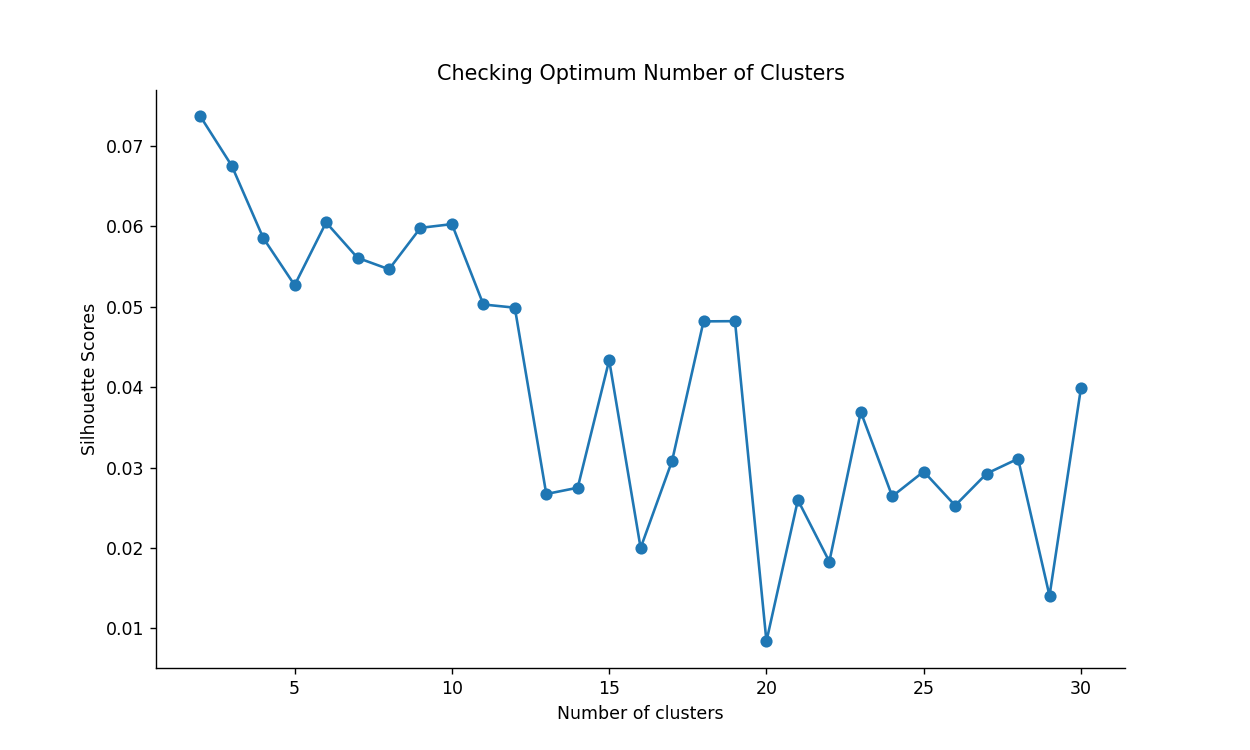

In [313]:
maxk = 30
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = ny_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df)
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)
    
print(scores)
print(kval)
plot(kval, scores)

We can see that the highest silhouette score with 2k, so I'm gonna set k = 2

In [314]:
k = 2

ny_clustering = ny_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(ny_clustering) 

kmeans.labels_

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,

In [301]:
ny_neigh.head()

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

In [318]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
ny_merged = neighborhoods
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [319]:
print(ny_merged.shape)
ny_merged.head()

(306, 10)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0,Pharmacy,Supermarket,Caribbean Restaurant,Donut Shop,Fried Chicken Joint
1,Bronx,Co-op City,40.874294,-73.829939,0,Department Store,Pizza Place,Mobile Phone Shop,Shopping Mall,Pharmacy
2,Bronx,Eastchester,40.887556,-73.827806,0,Caribbean Restaurant,Diner,Pizza Place,Shopping Mall,Fast Food Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,0,Bus Station,Pizza Place,Bar,Deli / Bodega,Mexican Restaurant
4,Bronx,Riverdale,40.890834,-73.912585,1,Bar,Park,Pizza Place,Bank,Bagel Shop


Visualize it!

In [320]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [341]:
ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[0] + [1] + list(range(5, ny_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,Pharmacy,Supermarket,Caribbean Restaurant,Donut Shop,Fried Chicken Joint
1,Bronx,Co-op City,Department Store,Pizza Place,Mobile Phone Shop,Shopping Mall,Pharmacy
2,Bronx,Eastchester,Caribbean Restaurant,Diner,Pizza Place,Shopping Mall,Fast Food Restaurant
3,Bronx,Fieldston,Bus Station,Pizza Place,Bar,Deli / Bodega,Mexican Restaurant
5,Bronx,Kingsbridge,Pizza Place,Mexican Restaurant,Bar,Sandwich Place,Coffee Shop
...,...,...,...,...,...,...,...
298,Bronx,Allerton,Pizza Place,Deli / Bodega,Donut Shop,Fried Chicken Joint,Caribbean Restaurant
299,Bronx,Kingsbridge Heights,Gym,Diner,Coffee Shop,Latin American Restaurant,Pizza Place
300,Brooklyn,Erasmus,Caribbean Restaurant,Discount Store,Mobile Phone Shop,Pharmacy,Pizza Place
303,Queens,Bayswater,Grocery Store,Playground,Park,Chinese Restaurant,Other Great Outdoors


### Cluster 2

In [322]:
ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[0] + [1] + list(range(5, ny_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Bronx,Riverdale,Bar,Park,Pizza Place,Bank,Bagel Shop
12,Bronx,City Island,Harbor / Marina,Seafood Restaurant,Italian Restaurant,Bar,Boat or Ferry
19,Bronx,High Bridge,Baseball Stadium,Lounge,Plaza,Bar,Park
24,Bronx,Hunts Point,Coffee Shop,Park,Home Service,Bakery,Construction & Landscaping
27,Bronx,Clason Point,Park,Discount Store,Bus Stop,Pool,Gym / Fitness Center
...,...,...,...,...,...,...,...
288,Queens,Roxbury,Art Gallery,Baseball Field,Theater,Beach,National Park
292,Staten Island,Lighthouse Hill,Italian Restaurant,Trail,Cosmetics Shop,Bagel Shop,History Museum
301,Manhattan,Hudson Yards,Gym / Fitness Center,Hotel,Theater,Coffee Shop,Lounge
302,Queens,Hammels,Beach,Surf Spot,Bar,Wine Bar,Pizza Place


## Results and Discussion

By analyzing the 2 clusters obtained we can see, both of them are suit for Bar. cuase the most common venues are Bars, Thus, the neighborhoods in these clusters would be well suited for opening a bar.


In [344]:
new_bar_neighborhoods = ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[0, 1, 2, 3] + list(range(5, ny_merged.shape[1]))]]
new_bar_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,Pharmacy,Supermarket,Caribbean Restaurant,Donut Shop,Fried Chicken Joint
1,Bronx,Co-op City,40.874294,-73.829939,Department Store,Pizza Place,Mobile Phone Shop,Shopping Mall,Pharmacy
2,Bronx,Eastchester,40.887556,-73.827806,Caribbean Restaurant,Diner,Pizza Place,Shopping Mall,Fast Food Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,Bus Station,Pizza Place,Bar,Deli / Bodega,Mexican Restaurant
5,Bronx,Kingsbridge,40.881687,-73.902818,Pizza Place,Mexican Restaurant,Bar,Sandwich Place,Coffee Shop


In [347]:
map_bar_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(new_bar_neighborhoods['Latitude'], new_bar_neighborhoods['Longitude'],
                                            new_bar_neighborhoods['Borough'], new_bar_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_bar_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bar_locations) 

map_bar_locations

## Conclusion

We have successfully analyzed the neighborhoods in New York for determining which would be the best neighborhoods for opening a new bar. Based on our analysis, neighborhoods in cluster 0 and 1 are recommended as locations for the new bar. This has also been plotted in the map above. The stakeholders and investors can further tune this by considering various other factors like transport, legal requirements, and costs associated. These were out of the scope for this project and thus were not considered.